In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys 
import os 

sys.path.append('../../../')
from src.athena import Athena
from src.utils import create_session

## Global

In [54]:
boto3_session = create_session(profile_name='dev', role_arn='arn:aws:iam::722696965592:role/athena-full-access-role')

database = 'data_bank'
tables = ['regions', 'customer_nodes', 'customer_transactions']
ctas_approach = False
wait = True

athena = Athena(boto3_session=boto3_session, s3_output=os.getenv('ATHENA_S3_OUTPUT'))
athena

Athena(boto3_session=Session(region_name='us-east-1'), s3_output=s3://sql-case-studies/query_results)

## Problem Statement

The financial industry is witnessing a transformative innovation with the advent of Neo-Banks: modern, digital-only banks that operate without physical branches.

Recognizing a unique opportunity at the intersection of digital banking, cryptocurrency, and data management, Danny has launched an ambitious initiative called Data Bank.

Data Bank functions as a conventional digital bank but distinguishes itself by offering the world's most secure distributed data storage platform alongside typical banking activities.

In this innovative model, customers are allocated cloud data storage limits directly proportional to their account balances. This novel approach presents several intriguing challenges and opportunities.

The management team at Data Bank seeks to expand their customer base while accurately tracking and predicting data storage requirements. They require assistance in navigating these complexities to ensure the initiative's success.

## Entity Relationship Diagram

<center>
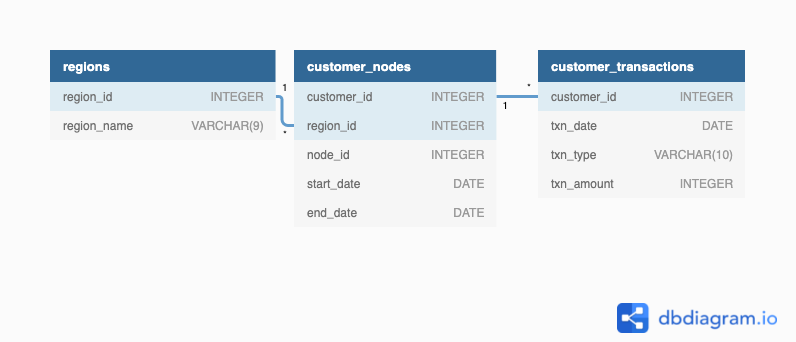
</center>

### Regions

The regions dimension table contains the regions in which the network nodes are located. 

### Customer Nodes

Customers are randomly distributed across the nodes within their regions. This is the fact table containing the customer, region, and node ID's as well as start and end dates for each customer's allocation to a node.

### Customer Transactions

The customer transactions table contains the transactions for each customer. The transactions are linked to the customer nodes table by the customer ID.


## Tables

In [7]:
for table in tables:
    athena.query(
        database=database,
        query=f""" 
                SELECT
                    *
                FROM
                    {database}.{table} TABLESAMPLE BERNOULLI(30);
              """,
        ctas_approach=ctas_approach
    )

,region_id,region_name
0,1,Australia


,customer_id,region_id,node_id,start_date,end_date
0,2,3,5,2020-01-03,2020-01-17
1,4,5,4,2020-01-07,2020-01-19
2,5,3,3,2020-01-15,2020-01-23
3,7,2,5,2020-01-20,2020-02-04
4,20,2,4,2020-01-18,2020-02-09
...,...,...,...,...,...
1002,491,3,5,2020-05-13,2262-04-11
1003,492,1,4,2020-05-06,2262-04-11
1004,493,4,3,2020-03-19,2262-04-11
1005,495,5,4,2020-05-07,2262-04-11


,customer_id,txn_date,txn_type,txn_amount
0,1,2020-01-02,deposit,312.0
1,1,2020-03-05,purchase,612.0
2,3,2020-02-22,purchase,965.0
3,3,2020-03-19,withdrawal,188.0
4,4,2020-01-21,deposit,390.0
...,...,...,...,...
1743,499,2020-03-12,deposit,754.0
1744,500,2020-03-07,purchase,452.0
1745,500,2020-03-01,purchase,929.0
1746,500,2020-01-30,deposit,922.0


## Duplicates

### Using CTE

Count the number of distinct rows in the tables:

In [63]:
for table in tables:

    query = f""" 
    WITH deduped_data AS (
      SELECT
        DISTINCT *
      FROM
        data_bank.{table}
    )
    SELECT
      COUNT(*) AS unique_count_{table}
    FROM
      deduped_data;
    """

    athena.query(
        database=database,
        query=query,
        ctas_approach=ctas_approach
    ) 

,unique_count_regions
0,5


,unique_count_customer_nodes
0,3500


,unique_count_customer_transactions
0,5868


### Grouping By All Columns & Counting

#### Customer Nodes

In [67]:
query = """ 
WITH grouped_counts AS (
  SELECT
    customer_id,
    region_id,
    node_id,
    start_date,
    end_date,
    COUNT(*) AS freq
  FROM
    data_bank.customer_nodes
  GROUP BY
    customer_id,
    region_id,
    node_id,
    start_date,
    end_date
)
SELECT
  *
FROM
  grouped_counts
WHERE
  freq > 1
ORDER BY
  freq DESC;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
) 

,customer_id,region_id,node_id,start_date,end_date,freq


#### Customer Transactions

In [3]:
query = """ 
WITH grouped_counts AS (
  SELECT
    customer_id,
    txn_date,
    txn_type,
    txn_amount,
    COUNT(*) AS freq
  FROM
    data_bank.customer_transactions
  GROUP BY
    customer_id,
    txn_date,
    txn_type,
    txn_amount
)
SELECT
  *
FROM
  grouped_counts
WHERE
  freq > 1
ORDER BY
  freq DESC;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,txn_date,txn_type,txn_amount,freq


No duplicate are identified in either table.

## Customer Nodes Exploration

## Q1 

How many unique nodes are there on the Data Bank system?

Because each region has a unique set of nodes, we can count unique combinations of region ID and node ID to get the total number of unique nodes across all regions.

In [55]:
query = """ 
SELECT
  r.region_name AS region_name,
  cn.node_id AS node_id,
  COUNT(*) AS region_node_count
FROM
  data_bank.customer_nodes AS cn LEFT JOIN data_bank.regions AS r ON cn.region_id = r.region_id
GROUP BY
  r.region_name, 
  cn.node_id
ORDER BY
  region_node_count DESC;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,region_name,node_id,region_node_count
0,America,1,174
1,Australia,4,168
2,Australia,5,157
3,Australia,1,154
4,America,5,154
5,Asia,3,153
6,Africa,4,151
7,Australia,3,146
8,America,3,146
9,Australia,2,145


## Q2

What is the number of nodes per region?

In [43]:
query = """ 
SELECT
  cn.region_id AS region_id,
  r.region_name AS region_name,
  COUNT(DISTINCT cn.node_id) AS unique_node_count
FROM
  data_bank.customer_nodes AS cn LEFT JOIN data_bank.regions AS r ON cn.region_id = r.region_id
GROUP BY
  cn.region_id,
  r.region_name
ORDER BY
    unique_node_count DESC;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,region_id,region_name,unique_node_count
0,3,Africa,5
1,2,America,5
2,1,Australia,5
3,4,Asia,5
4,5,Europe,5


## Q3

How many customers are allocated to each region?

In [54]:
query = """ 
SELECT
  r.region_name AS region_name,
  COUNT(DISTINCT cn.customer_id) AS unique_customer_count
FROM
  data_bank.customer_nodes AS cn LEFT JOIN data_bank.regions AS r ON cn.region_id = r.region_id
GROUP BY
  r.region_name
ORDER BY 
  unique_customer_count DESC;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,region_name,unique_customer_count
0,Australia,110
1,America,105
2,Africa,102
3,Asia,95
4,Europe,88


## Q4

How many days on average are customers reallocated to a different node?

In [88]:
query = """ 
WITH sanitized_dates AS (
  SELECT
    node_id,
    start_date,
    CASE
      WHEN end_date > CURRENT_DATE THEN CURRENT_DATE
      ELSE end_date
    END AS end_date
  FROM
    data_bank.customer_nodes
)
SELECT
  node_id,
  AVG(DATE_DIFF('day', start_date, end_date)) AS avg_day_at_node,
  AVG(DATE_DIFF('year', start_date, end_date)) AS avg_year_at_node
FROM
  sanitized_dates
GROUP BY
  node_id
ORDER BY 
  avg_day_at_node DESC;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,node_id,avg_day_at_node,avg_year_at_node
0,3,248.261803,0.606581
1,5,239.937765,0.588402
2,4,239.235795,0.585227
3,2,228.217523,0.555891
4,1,215.340659,0.521978


The CTE replaces all instances of `pandas.Timestamp.max = 2262-04-11 23:47:16` with the current timestamp:

In [91]:
query = """ 
SELECT
  node_id,
  start_date,
  CASE
    WHEN end_date > CURRENT_DATE THEN CURRENT_DATE
    ELSE end_date
  END AS end_date
FROM
    data_bank.customer_nodes;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,node_id,start_date,end_date
0,4,2020-01-02,2020-01-03
1,5,2020-01-03,2020-01-17
2,4,2020-01-27,2020-02-18
3,4,2020-01-07,2020-01-19
4,3,2020-01-15,2020-01-23
...,...,...,...
3495,4,2020-02-25,2024-07-17
3496,4,2020-05-27,2024-07-17
3497,2,2020-04-05,2024-07-17
3498,1,2020-02-03,2024-07-17


## Q5

What is the median, 80th and 95th percentile for this same reallocation days metric for each region?

In [92]:
query = """ 
WITH sanitized_dates AS (
  SELECT
    r.region_name AS region_name,
    cn.start_date AS start_date,
    CASE
      WHEN cn.end_date > CURRENT_DATE THEN CURRENT_DATE
      ELSE cn.end_date
    END AS end_date
  FROM
    data_bank.customer_nodes AS cn LEFT JOIN data_bank.regions AS r ON cn.region_id = r.region_id
)
SELECT
  region_name,
  APPROX_PERCENTILE(DATE_DIFF('day', start_date, end_date), 0.8) AS pct_80_days_at_node,
  APPROX_PERCENTILE(DATE_DIFF('day', start_date, end_date), 0.95) AS pct_95_days_at_node
FROM
  sanitized_dates
GROUP BY
  region_name
ORDER BY 
  region_name;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,region_name,pct_80_days_at_node,pct_95_days_at_node
0,Africa,27,1561
1,America,27,1560
2,Asia,27,1564
3,Australia,28,1559
4,Europe,28,1553


## Customer Transactions

## Q1 

What is the unique count and total amount for each transaction type?

In [9]:
query = """ 
SELECT
    txn_type AS transaction_type,
    COUNT(txn_type) AS total_count,
    SUM(txn_amount) AS total_amount
FROM
    data_bank.customer_transactions
GROUP BY
    txn_type
ORDER BY
    total_amount DESC;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,transaction_type,total_count,total_amount
0,deposit,2671,1359168.0
1,purchase,1617,806537.0
2,withdrawal,1580,793003.0


## Q2

What is the average total historical deposit counts and amounts for all customers?

In [57]:
query = """ 
WITH counts_data AS (
    SELECT
        COUNT(txn_type) AS deposit_count,
        SUM(txn_amount) AS deposit_amount
    FROM
        data_bank.customer_transactions
    WHERE
        txn_type = 'deposit'
    GROUP BY
        customer_id
)
SELECT
    ROUND(AVG(deposit_count)) AS avg_deposit_count,
    ROUND(SUM(deposit_amount) / SUM(deposit_count)) AS avg_deposit_amount
FROM
    counts_data;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,avg_deposit_count,avg_deposit_amount
0,5.0,509.0


## Q3

For each month - how many Data Bank customers make more than 1 deposit and either 1 purchase or 1 withdrawal within that month?

For each customer and month combination, we can count the number of deposits, purchases, and withdrawals using `CASE` statements:

In [9]:
query = """ 
SELECT
    customer_id,
    MONTH(txn_date) AS txn_month,
    SUM(CASE WHEN txn_type = 'deposit' THEN 1 ELSE 0 END) AS deposit_count,
    SUM(CASE WHEN txn_type = 'purchase' OR txn_type = 'withdrawal' THEN 1 ELSE 0 END) AS purchase_withdrawal_count
FROM
    data_bank.customer_transactions
GROUP BY
    customer_id, MONTH(txn_date);
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,txn_month,deposit_count,purchase_withdrawal_count
0,7,1,1,0
1,8,1,2,1
2,8,4,0,2
3,10,1,2,4
4,12,1,1,1
...,...,...,...,...
1715,497,4,1,1
1716,498,2,1,0
1717,498,4,1,0
1718,500,3,3,4


Group by `txn_month` and count the number of unique customers that meet the criteria:

* More than 1 deposit

* Either 1 purchase or 1 withdrawal

`WHERE` is executed before `GROUP BY`, which comes before `SELECT` in the order of operations. The data is first filtered to include only the rows where the customer made more than 1 deposit and either 1 purchase or 1 withdrawal; then the data is grouped by `txn_month` and the number of unique customers for each month is counted.

In [7]:
query = """ 
WITH counts_data AS (
    SELECT
        customer_id,
        MONTH(txn_date) AS txn_month,
        SUM(CASE WHEN txn_type = 'deposit' THEN 1 ELSE 0 END) AS deposit_count,
        SUM(CASE WHEN txn_type = 'purchase' OR txn_type = 'withdrawal' THEN 1 ELSE 0 END) AS purchase_withdrawal_count
    FROM
        data_bank.customer_transactions
    GROUP BY
        MONTH(txn_date), customer_id
)
SELECT
    txn_month AS month,
    COUNT(DISTINCT customer_id) AS customer_count
FROM
    counts_data
WHERE
    deposit_count > 1 
    AND purchase_withdrawal_count > 0
GROUP BY
    txn_month
ORDER BY
    txn_month;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,month,customer_count
0,1,168
1,2,181
2,3,192
3,4,70


## Q4

What is the closing balance for each customer at the end of the month?

First, check the unique transaction types:

In [21]:
query = """ 
SELECT
    DISTINCT txn_type
FROM
    data_bank.customer_transactions;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,txn_type
0,withdrawal
1,deposit
2,purchase


* Withdrawal should decrease the balance

* Purchase should decrease the balance

* Deposit should increase the balance

In [37]:
query = """ 
SELECT
    customer_id,
    txn_date,
    MONTH(txn_date) AS txn_month,
    CASE 
        WHEN txn_type IS NULL THEN NULL
        WHEN txn_type = 'deposit' THEN txn_amount 
        ELSE - txn_amount
    END AS txn_amount_net
FROM
    data_bank.customer_transactions
ORDER BY
    customer_id, txn_month;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,txn_date,txn_month,txn_amount_net
0,1,2020-01-02,1,312.0
1,1,2020-03-05,3,-612.0
2,1,2020-03-17,3,324.0
3,1,2020-03-19,3,-664.0
4,2,2020-01-03,1,549.0
...,...,...,...,...
5863,500,2020-03-22,3,-954.0
5864,500,2020-03-17,3,344.0
5865,500,2020-03-07,3,-452.0
5866,500,2020-03-11,3,-426.0


We can then use a second CTE to further compute the cumulative sum of the net transaction amounts for each customer and month. This ensures that we take into account the order of the transactions and the fact that the balance at the end of each month is cumulative. 

We use two window functions:

* `SUM()` partitions by customer ID and orders by transaction date in ascending order to calculate the cumulative sum of the net transaction amounts for each customer and month

* `ROW_NUMBER()` partitions by customer ID and orders by transaction date in descending order to assign a row number to each transaction for each customer; this allows us to filter for the last transaction of each month

In [43]:
query = """ 
WITH net_amounts AS (
    SELECT
        customer_id,
        txn_date,
        MONTH(txn_date) AS txn_month,
        CASE 
            WHEN txn_type IS NULL THEN NULL
            WHEN txn_type = 'deposit' THEN txn_amount 
            ELSE - txn_amount
        END AS txn_amount_net
    FROM
        data_bank.customer_transactions
    ORDER BY
        customer_id, txn_month
)
SELECT
    customer_id,
    txn_date,
    txn_month,
    txn_amount_net,
    SUM(txn_amount_net) OVER (
        PARTITION BY customer_id
        ORDER BY txn_date ASC
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
    ) AS month_end_balance,
    ROW_NUMBER() OVER (
        PARTITION BY customer_id, txn_month
        ORDER BY txn_date DESC
    ) AS row_num
FROM
    net_amounts
ORDER BY
    customer_id, txn_month, row_num DESC;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,txn_date,txn_month,txn_amount_net,month_end_balance,row_num
0,1,2020-01-02,1,312.0,312.0,1
1,1,2020-03-05,3,-612.0,-300.0,3
2,1,2020-03-17,3,324.0,24.0,2
3,1,2020-03-19,3,-664.0,-640.0,1
4,2,2020-01-03,1,549.0,549.0,1
...,...,...,...,...,...,...
5863,500,2020-03-07,3,-452.0,2462.0,5
5864,500,2020-03-11,3,-426.0,2036.0,4
5865,500,2020-03-17,3,344.0,2380.0,3
5866,500,2020-03-22,3,-954.0,1426.0,2


#### Example Calculation

For customer with ID 1, we can see that the closing balance for each month is calculated correctly.

* The closing balance for January is $\$312$

* The closing balance for February is $\$-640$

    - $312 - 612 + 324 - 664 = -640$

The final step is to filter for the last transaction of each month:

In [44]:
query = """ 
WITH net_amounts AS (
    SELECT
        customer_id,
        txn_date,
        MONTH(txn_date) AS txn_month,
        CASE 
            WHEN txn_type IS NULL THEN NULL
            WHEN txn_type = 'deposit' THEN txn_amount 
            ELSE - txn_amount
        END AS txn_amount_net
    FROM
        data_bank.customer_transactions
    ORDER BY
        customer_id, txn_month
),
cumulative_net_amounts AS (
    SELECT
        customer_id,
        txn_date,
        txn_month,
        txn_amount_net,
        SUM(txn_amount_net) OVER (
            PARTITION BY customer_id
            ORDER BY txn_date ASC
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS month_end_balance,
        ROW_NUMBER() OVER (
            PARTITION BY customer_id, txn_month
            ORDER BY txn_date DESC
        ) AS row_num
    FROM
        net_amounts
)
SELECT
    customer_id,
    txn_month,
    month_end_balance
FROM
    cumulative_net_amounts
WHERE
    row_num = 1
ORDER BY
    customer_id, txn_month;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,txn_month,month_end_balance
0,1,1,312.0
1,1,3,-640.0
2,2,1,549.0
3,2,3,610.0
4,3,1,144.0
...,...,...,...
1715,499,2,868.0
1716,499,3,599.0
1717,500,1,1594.0
1718,500,2,2981.0


## Q5

Compare the closing balance of a customer’s first month and the closing balance from their second month. 

* Percentages of customers with a negative and positive first month balance

* Percentage of customers who increased their opening month’s positive closing balance by more than $5\%$ in the following month

* Percentage of customers who reduced their opening month’s positive closing balance by more than $5\%$ in the following month

* Percentage of customers who move from a positive balance in the first month to a negative balance in the second month

### 1. Monthly Balance CTE

The first CTE computes the net transaction amount for each customer and month:

In [128]:
query = """ 
SELECT
    customer_id,
    DATE_TRUNC('month', txn_date) AS txn_month,
    SUM(
        CASE 
            WHEN txn_type IS NULL THEN NULL
            WHEN txn_type = 'deposit' THEN txn_amount 
            ELSE - txn_amount
        END
    ) AS txn_amount_net
FROM 
    data_bank.customer_transactions
GROUP BY 
    customer_id, DATE_TRUNC('month', txn_date)
ORDER BY 
    customer_id, DATE_TRUNC('month', txn_date);
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,txn_month,txn_amount_net
0,1,2020-01-01,312.0
1,1,2020-03-01,-952.0
2,2,2020-01-01,549.0
3,2,2020-03-01,61.0
4,3,2020-01-01,144.0
...,...,...,...
1715,499,2020-02-01,1719.0
1716,499,2020-03-01,-816.0
1717,500,2020-01-01,1594.0
1718,500,2020-02-01,1387.0


### 2. First and Second Month For Each Customer CTE

#### Minimum Month For Each Customer

In [129]:
query = """ 
SELECT 
    customer_id,
    DATE_TRUNC('month', MIN(txn_date)) AS min_txn_month
FROM 
    data_bank.customer_transactions
GROUP BY 
    customer_id;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,min_txn_month
0,3,2020-01-01
1,7,2020-01-01
2,14,2020-01-01
3,19,2020-01-01
4,21,2020-01-01
...,...,...
495,488,2020-01-01
496,491,2020-01-01
497,492,2020-01-01
498,495,2020-01-01


#### First and Second Month Via Cross Join With Generated Sequence

The `CROSS JOIN` creates a Cartesian product of each row in `min_txn_dates`, i.e., the minimum month for each customer, with the generated sequences 0 and 1 `UNNEST(SEQUENCE(0, 1))`

In [130]:
query = """ 
WITH min_txn_dates AS (
    SELECT 
        customer_id,
        DATE_TRUNC('month', MIN(txn_date)) AS min_txn_month
    FROM 
        data_bank.customer_transactions
    GROUP BY 
        customer_id
)
SELECT 
    customer_id, 
    month_offset
FROM 
    min_txn_dates,
    UNNEST(SEQUENCE(0, 1)) AS t (month_offset);
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,month_offset
0,1,0
1,1,1
2,6,0
3,6,1
4,8,0
...,...,...
995,481,1
996,483,0
997,483,1
998,493,0


The `DATE_ADD(unit, value, timestamp)` function adds a specified value to a timestamp, e.g. `DATE_ADD('month', 1, '2022-01-01')` returns `2022-02-01`:

In [131]:
query = """ 
WITH min_txn_dates AS (
    SELECT 
        customer_id,
        DATE_TRUNC('month', MIN(txn_date)) AS min_txn_month
    FROM 
        data_bank.customer_transactions
    GROUP BY 
        customer_id
)
SELECT 
    customer_id, 
    DATE_ADD('month', month_offset, min_txn_month) AS txn_month, 
    month_offset + 1 AS month_number
FROM 
    min_txn_dates,
    UNNEST(SEQUENCE(0, 1)) AS t (month_offset);
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,txn_month,month_number
0,3,2020-01-01,1
1,3,2020-02-01,2
2,7,2020-01-01,1
3,7,2020-02-01,2
4,14,2020-01-01,1
...,...,...,...
995,481,2020-02-01,2
996,483,2020-01-01,1
997,483,2020-02-01,2
998,493,2020-01-01,1


### 3. Monthly Transactions CTE

Left join the `monthly_balance_cte` CTE onto the `generated_months_cte` CTE to get the net transaction amount for each customer for the first and second month. 

Note that `COALESCE()` is used to replace `NULL` values with -999.

In [133]:
query = """ 
WITH monthly_balances_cte AS (
    SELECT
        customer_id,
        DATE_TRUNC('month', txn_date) AS txn_month,
        SUM(
            CASE 
                WHEN txn_type IS NULL THEN NULL
                WHEN txn_type = 'deposit' THEN txn_amount 
                ELSE - txn_amount
            END
        ) AS txn_amount_net
    FROM 
        data_bank.customer_transactions
    GROUP BY 
        customer_id, DATE_TRUNC('month', txn_date)
    ORDER BY 
        customer_id, DATE_TRUNC('month', txn_date)
),

first_second_months_cte AS (
  WITH min_txn_dates AS (
      SELECT 
          customer_id,
          DATE_TRUNC('month', MIN(txn_date)) AS min_txn_month
      FROM 
          data_bank.customer_transactions
      GROUP BY 
          customer_id
  )
  SELECT 
      customer_id, 
      DATE_ADD('month', month_offset, min_txn_month) AS txn_month, 
      month_offset + 1 AS month_number
  FROM 
      min_txn_dates,
      UNNEST(SEQUENCE(0, 1)) AS t (month_offset)
)
SELECT
    first_second_months_cte.customer_id,
    first_second_months_cte.txn_month,
    first_second_months_cte.month_number,
    COALESCE(monthly_balances_cte.txn_amount_net, -999) AS second_month_txn_amount_net
FROM 
    first_second_months_cte 
    LEFT JOIN 
        monthly_balances_cte 
    ON 
        first_second_months_cte.txn_month = monthly_balances_cte.txn_month
        AND first_second_months_cte.customer_id = monthly_balances_cte.customer_id;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,txn_month,month_number,second_month_txn_amount_net
0,2,2020-01-01,1,549.0
1,2,2020-02-01,2,-999.0
2,4,2020-01-01,1,848.0
3,4,2020-02-01,2,-999.0
4,5,2020-01-01,1,954.0
...,...,...,...,...
995,485,2020-02-01,2,1491.0
996,487,2020-01-01,1,-572.0
997,487,2020-02-01,2,884.0
998,490,2020-01-01,1,271.0


### 4. Monthly Aggregates CTE

This CTE uses the `LAG()` window function to create a new column, `first_month_txn_amount_net`, which contains the net transaction amount of the previous month for each customer. By doing this, it aligns the transaction amounts of consecutive months in the same row across two columns, allowing us to compare the balance of the current month with the balance of the previous month for each customer. 

In [138]:
query = """ 
WITH monthly_balances_cte AS (
    SELECT
        customer_id,
        DATE_TRUNC('month', txn_date) AS txn_month,
        SUM(
            CASE 
                WHEN txn_type IS NULL THEN NULL
                WHEN txn_type = 'deposit' THEN txn_amount 
                ELSE - txn_amount
            END
        ) AS txn_amount_net
    FROM 
        data_bank.customer_transactions
    GROUP BY 
        customer_id, DATE_TRUNC('month', txn_date)
    ORDER BY 
        customer_id, DATE_TRUNC('month', txn_date)
),

first_second_months_cte AS (
  WITH min_txn_dates AS (
      SELECT 
          customer_id,
          DATE_TRUNC('month', MIN(txn_date)) AS min_txn_month
      FROM 
          data_bank.customer_transactions
      GROUP BY 
          customer_id
  )
  SELECT 
      customer_id, 
      DATE_ADD('month', month_offset, min_txn_month) AS txn_month, 
      month_offset + 1 AS month_number
  FROM 
      min_txn_dates,
      UNNEST(SEQUENCE(0, 1)) AS t (month_offset)
),

monthly_transactions_cte AS (
    SELECT
        first_second_months_cte.customer_id,
        first_second_months_cte.txn_month,
        first_second_months_cte.month_number,
        COALESCE(monthly_balances_cte.txn_amount_net, -999) AS second_month_txn_amount_net
    FROM 
        first_second_months_cte 
        LEFT JOIN 
            monthly_balances_cte 
        ON 
            first_second_months_cte.txn_month = monthly_balances_cte.txn_month
            AND first_second_months_cte.customer_id = monthly_balances_cte.customer_id
)
SELECT
    customer_id,
    month_number,
    LAG(second_month_txn_amount_net) OVER (
        PARTITION BY customer_id
        ORDER BY txn_month
    ) AS first_month_txn_amount_net,
    second_month_txn_amount_net
FROM 
    monthly_transactions_cte;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_id,month_number,first_month_txn_amount_net,second_month_txn_amount_net
0,2,1,NaN,549.0
1,2,2,549.0,-999.0
2,4,1,NaN,848.0
3,4,2,848.0,-999.0
4,5,1,NaN,954.0
...,...,...,...,...
995,485,2,16.0,1491.0
996,487,1,NaN,-572.0
997,487,2,-572.0,884.0
998,490,1,NaN,271.0


### 5. Final Calculations

The following calculations are performed:

---

1. Total count of unique customers without missing balance in the second month after the first month, i.e., `second_month_txn_amount_net <> -999`.

```sql
COUNT(DISTINCT customer_id) AS customer_count
```

---

2. Total count customers with positive and negative balance in the first month:

```sql
SUM(CASE WHEN first_month_txn_amount_net > 0 THEN 1 ELSE 0 END) AS positive_first_month_count
SUM(CASE WHEN first_month_txn_amount_net < 0 THEN 1 ELSE 0 END) AS negative_first_month_count
```

---

3. Total count of customers with positive balance in the first month and increased or decreased by more than $5\%$ in the second month:

```sql
SUM(CASE
        WHEN first_month_txn_amount_net > 0
                AND second_month_txn_amount_net > 0
                AND second_month_txn_amount_net > 1.05 * first_month_txn_amount_net
        THEN 1
        ELSE 0
    END
) AS second_month_5_pct_higher_count

SUM(
    CASE
        WHEN first_month_txn_amount_net > 0
                AND second_month_txn_amount_net < 0
                AND second_month_txn_amount_net < 0.95 * first_month_txn_amount_net
        THEN 1
        ELSE 0
    END
) AS second_month_5_pct_lower_count
```

---

4. Total count of customers with positive balance in the first month and negative balance in the second month:

```sql
SUM(
    CASE
    WHEN first_month_txn_amount_net > 0
        AND second_month_txn_amount_net < 0
        AND second_month_txn_amount_net < -first_month_txn_amount_net
        THEN 1
    ELSE 0 END
) AS positive_to_negative_count
```

In [141]:
query = """ 
WITH monthly_balances_cte AS (
    SELECT
        customer_id,
        DATE_TRUNC('month', txn_date) AS txn_month,
        SUM(
            CASE 
                WHEN txn_type IS NULL THEN NULL
                WHEN txn_type = 'deposit' THEN txn_amount 
                ELSE -txn_amount
            END
        ) AS txn_amount_net
    FROM 
        data_bank.customer_transactions
    GROUP BY 
        customer_id, DATE_TRUNC('month', txn_date)
    ORDER BY 
        customer_id, DATE_TRUNC('month', txn_date)
),

first_second_months_cte AS (
  WITH min_txn_dates AS (
      SELECT 
          customer_id,
          DATE_TRUNC('month', MIN(txn_date)) AS min_txn_month
      FROM 
          data_bank.customer_transactions
      GROUP BY 
          customer_id
  )
  SELECT 
      customer_id, 
      DATE_ADD('month', month_offset, min_txn_month) AS txn_month, 
      month_offset + 1 AS month_number
  FROM 
      min_txn_dates,
      UNNEST(SEQUENCE(0, 1)) AS t (month_offset)
),

monthly_transactions_cte AS (
    SELECT
        first_second_months_cte.customer_id,
        first_second_months_cte.txn_month,
        first_second_months_cte.month_number,
        COALESCE(monthly_balances_cte.txn_amount_net, -999) AS second_month_txn_amount_net
    FROM 
        first_second_months_cte 
        LEFT JOIN 
            monthly_balances_cte 
        ON 
            first_second_months_cte.txn_month = monthly_balances_cte.txn_month
            AND first_second_months_cte.customer_id = monthly_balances_cte.customer_id
),

first_second_month_alignment_cte AS (
    SELECT
        customer_id,
        month_number,
        LAG(second_month_txn_amount_net) OVER (
            PARTITION BY customer_id
            ORDER BY txn_month
        ) AS first_month_txn_amount_net,
        second_month_txn_amount_net
    FROM 
        monthly_transactions_cte
)
SELECT
    COUNT(DISTINCT customer_id) AS customer_count,
    SUM(CASE WHEN first_month_txn_amount_net > 0 THEN 1 ELSE 0 END) AS positive_first_month_count,
    SUM(CASE WHEN first_month_txn_amount_net < 0 THEN 1 ELSE 0 END) AS negative_first_month_count,
    SUM(CASE
            WHEN first_month_txn_amount_net > 0
                 AND second_month_txn_amount_net > 0
                 AND second_month_txn_amount_net > 1.05 * first_month_txn_amount_net
            THEN 1
            ELSE 0
        END
    ) AS second_month_5_pct_higher_count,
    SUM(
        CASE
            WHEN first_month_txn_amount_net > 0
                 AND second_month_txn_amount_net < 0
                 AND second_month_txn_amount_net < 0.95 * first_month_txn_amount_net
            THEN 1
            ELSE 0
        END
    ) AS second_month_5_pct_lower_count,
    SUM(
        CASE
        WHEN first_month_txn_amount_net > 0
            AND second_month_txn_amount_net < 0
            AND second_month_txn_amount_net < -first_month_txn_amount_net
            THEN 1
        ELSE 0 END
    ) AS positive_to_negative_count
FROM 
    first_second_month_alignment_cte
WHERE 
    first_month_txn_amount_net IS NOT NULL
    AND second_month_txn_amount_net <> -999;
"""


athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,customer_count,positive_first_month_count,negative_first_month_count,second_month_5_pct_higher_count,second_month_5_pct_lower_count,positive_to_negative_count
0,455,304,151,63,175,114


### Putting It All Together

In [143]:
query = """ 
WITH monthly_balances_cte AS (
    SELECT
        customer_id,
        DATE_TRUNC('month', txn_date) AS txn_month,
        SUM(
            CASE 
                WHEN txn_type IS NULL THEN NULL
                WHEN txn_type = 'deposit' THEN txn_amount 
                ELSE -txn_amount
            END
        ) AS txn_amount_net
    FROM 
        data_bank.customer_transactions
    GROUP BY 
        customer_id, DATE_TRUNC('month', txn_date)
    ORDER BY 
        customer_id, DATE_TRUNC('month', txn_date)
),

first_second_months_cte AS (
  WITH min_txn_dates AS (
      SELECT 
          customer_id,
          DATE_TRUNC('month', MIN(txn_date)) AS min_txn_month
      FROM 
          data_bank.customer_transactions
      GROUP BY 
          customer_id
  )
  SELECT 
      customer_id, 
      DATE_ADD('month', month_offset, min_txn_month) AS txn_month, 
      month_offset + 1 AS month_number
  FROM 
      min_txn_dates,
      UNNEST(SEQUENCE(0, 1)) AS t (month_offset)
),

monthly_transactions_cte AS (
    SELECT
        first_second_months_cte.customer_id,
        first_second_months_cte.txn_month,
        first_second_months_cte.month_number,
        COALESCE(monthly_balances_cte.txn_amount_net, -999) AS second_month_txn_amount_net
    FROM 
        first_second_months_cte 
        LEFT JOIN 
            monthly_balances_cte 
        ON 
            first_second_months_cte.txn_month = monthly_balances_cte.txn_month
            AND first_second_months_cte.customer_id = monthly_balances_cte.customer_id
),

first_second_month_alignment_cte AS (
    SELECT
        customer_id,
        month_number,
        LAG(second_month_txn_amount_net) OVER (
            PARTITION BY customer_id
            ORDER BY txn_month
        ) AS first_month_txn_amount_net,
        second_month_txn_amount_net
    FROM 
        monthly_transactions_cte
),

calculations_cte AS (
    SELECT
        COUNT(DISTINCT customer_id) AS customer_count,
        SUM(CASE WHEN first_month_txn_amount_net > 0 THEN 1 ELSE 0 END) AS positive_first_month_count,
        SUM(CASE WHEN first_month_txn_amount_net < 0 THEN 1 ELSE 0 END) AS negative_first_month_count,
        SUM(CASE
                WHEN first_month_txn_amount_net > 0
                    AND second_month_txn_amount_net > 0
                    AND second_month_txn_amount_net > 1.05 * first_month_txn_amount_net
                THEN 1
                ELSE 0
            END
        ) AS second_month_5_pct_higher_count,
        SUM(
            CASE
                WHEN first_month_txn_amount_net > 0
                    AND second_month_txn_amount_net < 0
                    AND second_month_txn_amount_net < 0.95 * first_month_txn_amount_net
                THEN 1
                ELSE 0
            END
        ) AS second_month_5_pct_lower_count,
        SUM(
            CASE
            WHEN first_month_txn_amount_net > 0
                AND second_month_txn_amount_net < 0
                AND second_month_txn_amount_net < -first_month_txn_amount_net
                THEN 1
            ELSE 0 END
        ) AS positive_to_negative_count
    FROM 
        first_second_month_alignment_cte
    WHERE 
        first_month_txn_amount_net IS NOT NULL
        AND second_month_txn_amount_net <> -999
)
SELECT
  ROUND(100 * positive_first_month_count / customer_count, 2) AS positive_pct,
  ROUND(100 * negative_first_month_count / customer_count, 2) AS negative_pct,
  ROUND(100 * second_month_5_pct_higher_count / positive_first_month_count, 4) AS second_month_5_pct_higher_pct,
  ROUND(100 * second_month_5_pct_lower_count / positive_first_month_count, 4) AS second_month_5_pct_lower_pct,
  ROUND(100 * positive_to_negative_count / positive_first_month_count, 4) AS positive_to_negative_pct
FROM 
  calculations_cte;
"""

athena.query(
    database=database,
    query=query,
    ctas_approach=ctas_approach
)

,positive_pct,negative_pct,second_month_5_pct_higher_pct,second_month_5_pct_lower_pct,positive_to_negative_pct
0,66,33,20,57,37
